In [1]:
# Package imports
import pandas as pd
import polars as pl
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, r2_score

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline


In [2]:
def count_csv_rows(filepath):
    with open(filepath, 'rb') as f:  # Open in binary mode for speed
        return sum(1 for line in f)

csv_path = "C:/group_project_data.csv"
row_count = count_csv_rows(csv_path)
print(f"Number of rows: {row_count}")

Number of rows: 868971


In [3]:
# ----- Use the lazy API to load and transform data -----
# Use scan_csv to create a LazyFrame (does not immediately load all data into RAM)
lazy_df = pl.scan_csv("C:/group_project_data.csv")

In [4]:
# Chain all transformations in lazy mode:
lazy_transformed = (
    lazy_df
    # Create the target variable from existing columns
    .with_columns((pl.col('HSEP001S') / pl.col('HSHNIAGG')).alias('target'))
    # Drop a column directly
    .drop("CODE")
)

# List of columns to drop (only keep those that exist in the schema)
columns_to_drop = [
    "HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", "HSTX001", "HSEP001S",
    "HSSH006", "HSSH015", "HSSH019", "HSSH044", "HSHC022", "HSHC025",
    "HSTR032", "ECYINDFINA", "ECYHRIHHD", "ECYHRI_020", "ECYHRI2040",
    "ECYHRI4060", "ECYHRI6080", "ECYHRIX100", "ECYHRI100P", "ECYHRIX125",
    "ECYHRIX150", "ECYHRIX200", "ECYHRI200P", "ECYHRIX300", "ECYHRI300P",
    "ECYHRIAVG", "ECYHRIMED", "ECYHRIAGG", "ECYHNIHHD", "ECYHNI_020",
    "ECYHNI2040", "ECYHNI4060", "ECYHNI6080", "ECYHNIX100", "ECYHNI100P",
    "ECYHNIX125", "ECYHNIX150", "ECYHNIX200", "ECYHNI200P", "ECYHNIX300",
    "ECYHNI300P", "ECYHNIAVG", "ECYHNIMED", "ECYHNIAGG", "ECYPNIHP15",
    "ECYPNININ", "ECYPNIWIN", "ECYPNIAVG"
]
# Filter out any columns not present in the data (using lazy frame's schema)
existing_cols = [col for col in columns_to_drop if col in lazy_transformed.columns]
lazy_transformed = lazy_transformed.drop(existing_cols)

# Remove rows with nulls or NaN in 'target'
lazy_transformed = (
    lazy_transformed
    .drop_nulls(subset=["target"])
    .filter(~pl.col("target").is_nan())
)

# Collect into eager DataFrame
merged_df = lazy_transformed.collect()

C:\Users\mrezae7\AppData\Local\Temp\ipykernel_18148\1915022296.py:24: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  existing_cols = [col for col in columns_to_drop if col in lazy_transformed.columns]


In [5]:
# If you have categorical variables – e.g., "GEO" – and you wish to one-hot encode:
# In case "GEO" always has a single unique value, this operation will result in a single dummy.
merged_df = merged_df.to_dummies(columns=['GEO'], drop_first=True)

# ----- Inspect and process the collected DataFrame -----
print(merged_df.head())
print(f"Shape after transformation: {merged_df.shape}")

shape: (5, 444)
┌──────────┬───────────┬────────────┬────────────┬───┬──────────────┬─────────────┬──────────────┬──────────┐
│ ECYASQKM ┆ ECYALSQKM ┆ ECYBASPOP  ┆ ECYBASTNGH ┆ … ┆ HSTR056A     ┆ HSTR056B    ┆ HSTR057      ┆ target   │
│ ---      ┆ ---       ┆ ---        ┆ ---        ┆   ┆ ---          ┆ ---         ┆ ---          ┆ ---      │
│ i64      ┆ i64       ┆ f64        ┆ f64        ┆   ┆ f64          ┆ f64         ┆ f64          ┆ f64      │
╞══════════╪═══════════╪════════════╪════════════╪═══╪══════════════╪═════════════╪══════════════╪══════════╡
│ 0        ┆ 0         ┆ 55.0       ┆ 0.0        ┆ … ┆ 1132.355623  ┆ 562.557865  ┆ 707.665394   ┆ 0.04     │
│ 0        ┆ 0         ┆ 571.197529 ┆ 38.0       ┆ … ┆ 8089.461528  ┆ 3995.11955  ┆ 9687.319907  ┆ 0.059753 │
│ 0        ┆ 0         ┆ 571.197529 ┆ 40.47709   ┆ … ┆ 16062.241477 ┆ 6783.786567 ┆ 13747.017489 ┆ 0.052055 │
│ 0        ┆ 0         ┆ 452.0      ┆ 35.0       ┆ … ┆ 5897.805493  ┆ 2931.427257 ┆ 7163.833309  ┆ 0.056

In [6]:
# ----- Train-test-val split -----
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    merged_df.drop('target'),
    merged_df.select('target'),
    test_size=0.1,
    random_state=0
)

Xtrain_main, Xval, ytrain_main, yval = train_test_split(
    Xtrain,
    ytrain,
    test_size=0.12,
    random_state=0
)

print("Training set shapes:", Xtrain_main.shape, ytrain_main.shape)
print("validation set shapes:", Xval.shape, yval.shape)
print("Testing set shapes:", Xtest.shape, ytest.shape)

Training set shapes: (614797, 443) (614797, 1)
validation set shapes: (83837, 443) (83837, 1)
Testing set shapes: (77627, 443) (77627, 1)


In [8]:
del merged_df

In [9]:
# Define the grid of alpha and l1_ratio values
alpha_values = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.5, 0.9]

best_score = float('inf')
best_params = None

# Placeholder to store best pipeline
best_pipe = None

for alpha in alpha_values:
    for l1_ratio in l1_ratios:
        elastic_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('elasticnet', ElasticNet(
                alpha=alpha,
                l1_ratio=l1_ratio,
                max_iter=10000,
                random_state=42
            ))
        ])
        
        # Fit on training subset
        elastic_pipe.fit(Xtrain_main, ytrain_main.to_numpy().ravel())
        
        # Predict on validation set
        preds = elastic_pipe.predict(Xval)
        rmse = mean_squared_error(yval, preds)

        print(f"alpha={alpha}, l1_ratio={l1_ratio}, RMSE={rmse:.10f}")

        # Keep the best performing pipeline
        if rmse < best_score:
            best_score = rmse
            best_params = (alpha, l1_ratio)
            best_pipe = elastic_pipe  # Save the pipeline

# Assign the best performing pipeline back to elastic_pipe
elastic_pipe = best_pipe

print(f"\n✅ Best Params according to val set: alpha={best_params[0]}, l1_ratio={best_params[1]}, RMSE={best_score:.4f}")


alpha=0.001, l1_ratio=0.1, RMSE=0.0001900807
alpha=0.001, l1_ratio=0.5, RMSE=0.0002031914
alpha=0.001, l1_ratio=0.9, RMSE=0.0002122454
alpha=0.01, l1_ratio=0.1, RMSE=0.0002149143
alpha=0.01, l1_ratio=0.5, RMSE=0.0002490746
alpha=0.01, l1_ratio=0.9, RMSE=0.0002490746
alpha=0.1, l1_ratio=0.1, RMSE=0.0002490746
alpha=0.1, l1_ratio=0.5, RMSE=0.0002490746
alpha=0.1, l1_ratio=0.9, RMSE=0.0002490746
alpha=1, l1_ratio=0.1, RMSE=0.0002490746
alpha=1, l1_ratio=0.5, RMSE=0.0002490746
alpha=1, l1_ratio=0.9, RMSE=0.0002490746
alpha=10, l1_ratio=0.1, RMSE=0.0002490746
alpha=10, l1_ratio=0.5, RMSE=0.0002490746
alpha=10, l1_ratio=0.9, RMSE=0.0002490746

✅ Best Params according to val set: alpha=0.001, l1_ratio=0.1, RMSE=0.0002


In [ ]:
# ----- Saving the model -----
with open('elastic_pipe_model.pkl', 'wb') as f:
    pickle.dump(elastic_pipe, f)

In [ ]:
# ----- Loading the model -----
with open('elastic_pipe_model.pkl', 'rb') as f:
    elastic_pipe = pickle.load(f)

In [16]:
# ----- Testing and results -----
y_pred = elastic_pipe.predict(Xtest)
ytest = ytest.to_numpy()

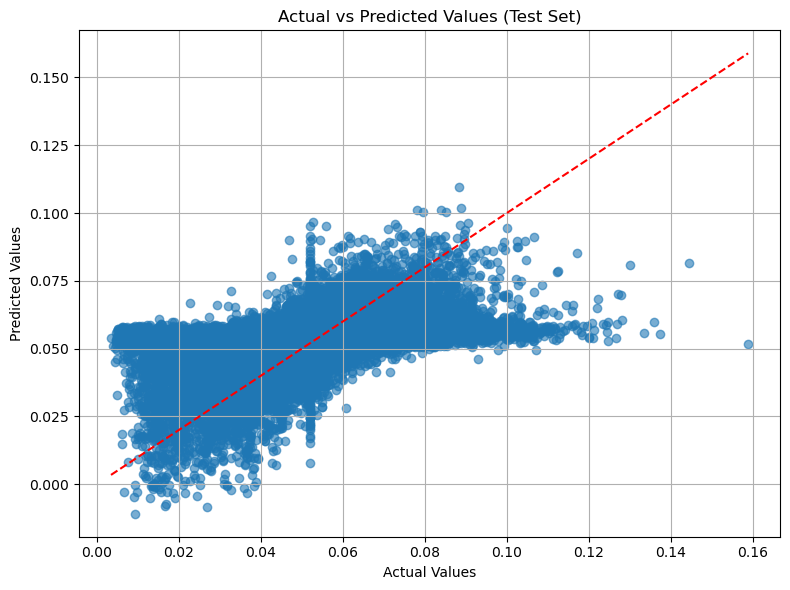

In [17]:
# Plot: Actual vs Predicted values (Test Set)
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Metrics: Mean Squared Error and R² Score
mse = mean_squared_error(ytest, y_pred)
r2 = r2_score(ytest, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0002
R² Score: 0.2321


In [19]:
# Bootstrapping confidence intervals
n_bootstraps = 100
bootstrapped_MSE = np.zeros(n_bootstraps)
bootstrapped_r2 = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    idx = np.random.choice(len(ytest), len(ytest), replace=True)
    bootstrapped_MSE[i] = mean_squared_error(ytest[idx], y_pred[idx])
    bootstrapped_r2[i] = r2_score(ytest[idx], y_pred[idx])

mse_diff = bootstrapped_MSE - mse
r2_diff = bootstrapped_r2 - r2

mse_ci = np.percentile(mse_diff, [2.5, 97.5])
r2_ci = np.percentile(r2_diff, [2.5, 97.5])

print(f"The 95% confidence interval for the mse is [{(mse - mse_ci[1])*100:.4f}%, {(mse - mse_ci[0])*100:.4f}%]")
print(f"The 95% confidence interval for the r2 is [{(r2 - r2_ci[1]):.4f}, {(r2 - r2_ci[0]):.4f}]")


The 95% confidence interval for the mse is [0.0188%, 0.0193%]
The 95% confidence interval for the r2 is [0.2278, 0.2362]


In [24]:
# ----- Interpreting the coefficients -----
variables = Xtrain.columns
coefficients = elastic_pipe.named_steps['elasticnet'].coef_
coef_df = pd.DataFrame({'Variable': variables, 'Coefficient': coefficients})

In [26]:
# Display top five coefficients (by absolute value)
coef_df_sorted = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)
top_five_coefs = coef_df_sorted.head(5)
print(top_five_coefs)

       Variable  Coefficient
402     HSHO021    -0.002476
79   ECYINDPUBL     0.002408
437     HSTR052    -0.002403
403     HSCC003     0.001907
346   ECYPIMP01    -0.001770
